# Modeling Demand for Cars with Inverse Product Differentiation Logit

In this notebook, we will explore the dataset used in
Brownstone and Train (1999). We will estimate the Inverse Product Differentiation Logit
model given the available data using the functions defined below.


In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter

Data
====

The data consists of a survey of households regarding their preferences
for car purchase. Each household was given 6 options, but the
characteristics that the respondents were asked about was varied. The
surveys were originally conducted in order to illicit consumer
preferences for alternative-fuel vehicles. The data is *stated
preferences*, in the sense that consumers did not actually buy but just
stated what they would hypothetically choose, which is of course a
drawback. This is very common in marketing when historic data is either
not available or does not provide satisfactory variation. The advantage
of the stated preference data is therefore that the choice set can be
varied greatly (for example, the characteristics includes the
availability of recharging stations, which is important for purchase of
electric cars).

The data has $N=4654$ respondents with $J=6$ cars to choose
from.

Loading the dataset, `car_data.csv`, we get a dataframe with 
$NJ = 27,924$ rows. The column `person_id` runs through $0,1,...,N-1$, and
the column `j` is the index for the car, $\{0,1,...,5\}$. The variable 
`binary_choice` is a dummy, =1 for the car chosen by the respondent. 
A conveneint other variable, `y`, is the index for that car, repeated 
and identical for all $J$ rows for each person. The x-variables describe 
the characteristics of the 6 cars that the respondent was asked to choose 
from. 

We also read in the dataset `car_labels.csv`, which contains the 
variable labels and descriptions for all the variables. 
The lists `x_vars` and `x_lab` will be used throughout as the list of 
explanatory variables we want to work with. 

In order to get the data into a 3-dimensional array, we access 
the underlying numpy arrays and resize them. For example 

> `x = dat[x_vars].values.resize((N,J,K))`

Note that this will only work because the data is sorted according to 
first `person_id` and then `j`. You can test this by verifying that 
`x[0,:,k]` prints the same as `dat.loc[dat.person_id == 0, x_vars[k]]`. 

In [2]:
# Load dataset and variable names
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
dat = pd.read_csv(os.path.join(input_path, 'car_data.csv'))
lab = pd.read_csv(os.path.join(input_path, 'car_labels.csv'), index_col = 'variable')

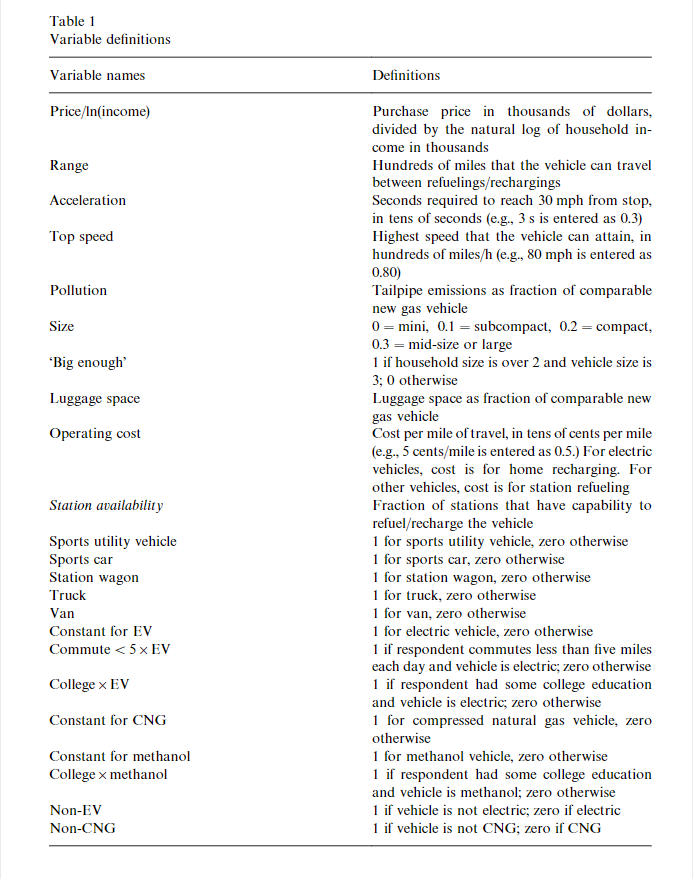

In [3]:
display.Image('brownstone_train_tab_1.PNG')

Table 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

## Scaling variables

To be consistent with the interpretation of estimates in 'Brownstone & Train (1999)' we rescale some of the explanatory variables. Furthermore, Logit models are most stable numerically if we ensure that variables are scaled near to $\pm 1$. 

In [4]:
dat['range'] = dat['range'] / 100                  # Hundreds of miles that the vehicle can travel between fuelings
dat['top_speed'] = dat['top_speed'] / 100          # Highest speed that the vehicle can attain, in hundreds of miles per hour
dat['size'] = dat['size'] / 10                     # Scaled categorical variable for numerical purposes
dat['acceleration'] = dat['acceleration'] / 10     # Measured in tens of seconds
dat['operating_cost'] = dat['operating_cost'] / 10 # Measured in tens of cents per mile

Since, respectively, 'EV'and 'Non-EV'and 'CNG' and 'Non-CNG' are equivalent we exclude the latter and keep all the other characteristics as explanatory variables.  

In [5]:
# variables to use as explanatory variables
x_vars = list(lab.iloc[3:-4].index.values) # variable names

In [6]:
# dimensions of data
N = dat.person_id.nunique()
J = dat.j.nunique()
K = len(x_vars)

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [7]:
# response and explanatory variables as numpy arrays
y = dat['y'].values.reshape((N,J))
y = y[:, 0] # All values are equal along axis=1. Becomes an (N,) array i.e. it is a vector.
x = dat[x_vars].values.reshape((N,J,K))

We assume the vector of payoffs of the products are given by a linear index $u(X_i,\beta)=X_i\beta$, where $X_i$ is the $J\times K$ matrix of regressors for individual $i$ collected in the array
```x```.

## Estimating the logit model

In the logit model, the map from payoffs to choice probabilities are given by $P^{logit}(v)=\frac{\exp(v)}{\sum_j \exp(v_j)}$. The conditional choice probability function is then
$$
p^{logit}(X_i,\beta)=P^{logit}(u(X_i,\beta))
$$



For comparison, we first estimate a logit model on the data using maximum likelihood. In doing this we will see our first use of the numpy function 'einsum()' which quickly and easily computes matrix products, outer products, transposes, etc. 

In [8]:
def util(Beta, x):
    '''
    This function finds the deterministic utilities u = X*Beta.
    
    Args.
        Beta: (K,) numpy array of parameters
        x: (N,J,K) matrix of covariates

    Output
        u: (N,J) matrix of deterministic utilities
    '''

    assert Beta.ndim == 1
    assert x.ndim == 3

    u = np.einsum('njk,k->nj', x, Beta) # is the same as x @ Beta

    return u

In [9]:
def logit_loglikehood(Beta, y, x, MAXRESCALE: bool = True):
    '''
    This function calculates the likelihood contributions of a Logit model

    Args. 
        Beta: (K,) vector of parameters 
        x: (N,J,K) matrix of covariates 
        y: (N,) vector of outcomes (integers in 0, 1, ..., J-1)

    Returns
        ll_i: (N,) vector of loglikelihood contributions for a Logit
    '''
    assert Beta.ndim == 1 
    N,J,K = x.shape 

    # deterministic utility 
    v = util(Beta, x)

    if MAXRESCALE: 
        # subtract the row-max from each observation
        v -= v.max(axis=1, keepdims=True)  # keepdims maintains the second dimension, (N,1), so broadcasting is successful

    # denominator 
    denom = np.exp(v).sum(axis=1) # NOT keepdims! becomes (N,)

    # utility at chosen alternative for each individual i
    v_i = v[np.arange(N), y] # Becomes (N,)

    # likelihood 
    ll_i = v_i - np.log(denom) # difference between two 1-dimensional arrays 

    return ll_i


In [10]:
def q_logit(Beta, y, x):
    
    '''
    q: Criterion function, passed to estimate_logit().
    '''
    return -logit_loglikehood(Beta, y, x)

In [11]:
def estimate_logit(q, Beta0, y, x, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args.
        q: a function to minimize,
        Beta0 : (K+G,) array of initial guess parameters,
        y: array of observed response variables (N,),
        x: array of observed explanatory variables (N,J,K),
        options: dictionary with options for the optimizer (e.g. disp=True,
            which tells it to display information at termination.)
    
    Returns
        res: Returns a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(q(Theta, y, x))

    # call optimizer
    result = optimize.minimize(Q, Beta0.tolist(), options=options, **kwargs)

    # collect output in a dict 
    res = {
        'beta': result.x, # vector of estimated parameters
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields...

In [131]:
beta_0 = np.zeros((K,))

# Estimate the model
res_logit = estimate_logit(q_logit, beta_0, y, x)

Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 1914
         Gradient evaluations: 87


In [132]:
logit_beta = res_logit['beta']
pd.DataFrame(logit_beta.reshape(1,len(logit_beta)))

0         1         2         3         4         5         6   \
0 -0.185425  0.350097 -0.716186  0.261102 -0.444102  0.934359  0.143349   

         7         8         9   ...       11        12        13       14  \
0  0.502492 -0.767961  0.413064  ...  0.63611 -1.436669 -1.016813 -0.79894   

         15        16        17        18        19        20  
0 -0.179022  0.198374  0.442935  0.345063  0.313123  0.228548  

[1 rows x 21 columns]

### We then compute the corresponding Logit choice probabilities

In [133]:
def logit_ccp(Beta, x, MAXRESCALE:bool=True):
    '''logit_ccp(): Computes the (N,J) matrix of choice probabilities from a logit model
    Args. 
        u: (N,J) matrix of  
    
    Returns
        ccp: (N,J) matrix of probabilities 
    '''
    
    # deterministic utility 
    v = util(Beta, x) # (N,J) 

    if MAXRESCALE: 
        # subtract the row-max from each observation
        v -= v.max(axis=1, keepdims=True)  # keepdims maintains the second dimension, (N,1), so broadcasting is successful
    
    # denominator 
    denom = np.exp(v).sum(axis=1, keepdims=True) # (N,1)
    
    # Conditional choice probabilites
    ccp = np.exp(v) / denom
    
    return ccp

For our purposes, the choice probabilities $\hat q_i^{logit}$ of products $\{0,1, \ldots , 5\}$ for individuals $i=0,1,\ldots , 4653$ thus becomes:

In [134]:
logit_q = logit_ccp(logit_beta, x)
pd.DataFrame(logit_q)

0         1         2         3         4         5
0     0.137636  0.305989  0.207764  0.109801  0.132362  0.106449
1     0.236860  0.106541  0.285763  0.067931  0.222439  0.080467
2     0.199514  0.072173  0.235710  0.106024  0.312332  0.074247
3     0.136256  0.049290  0.171101  0.076962  0.457609  0.108782
4     0.086728  0.031373  0.167618  0.075396  0.516180  0.122705
...        ...       ...       ...       ...       ...       ...
4649  0.166531  0.060242  0.206095  0.092703  0.383310  0.091120
4650  0.220779  0.079866  0.320608  0.144211  0.189491  0.045046
4651  0.119780  0.148937  0.044177  0.029030  0.174817  0.483259
4652  0.055318  0.152921  0.267973  0.333206  0.115007  0.075576
4653  0.096796  0.043539  0.214610  0.051017  0.436233  0.157805

[4654 rows x 6 columns]

The logit (semi-) elasticities of the choice probabilities $q_i = P(X_i, \theta)$ for individual i wrt. to the $\ell$'th characteristic are given by the formula:
$ \mathcal{E}_i= \nabla_x \ln P(X_i, \theta)= \left( I_J - \iota q_i'\right) \theta_\ell$
where $()'$ denotes the transpose of a matrix.

Lastly we compute the implied price-to-log-income elasticities for our logit model.

In [135]:
def logit_elasticity(q, Beta, char_number):
    ''' 
    This function calculates the logit elasticities of choice probabilities wrt. a given charateristic k

    Args.
        q: a (N,J) numpy array of choice probabilities
        Beta: a (K,) numpy array of parameters
        car_number: an integer k for the index of the characteristic

    Output:
        Epsilon: a (N,J,J) matrix of logit elasticities of choice probabilities wrt. the charateristic k
    '''

    assert q.ndim == 2
    assert Beta.ndim == 1

    N,J = q.shape

    iota_q = np.einsum('j,ni->nji', np.ones((J,)), q)
    Epsilon = (np.eye(J) - iota_q)*Beta[char_number]

    return Epsilon

Implemented on our datset, we thus find the elasticities as follows...

In [136]:
epsilon_logit = logit_elasticity(logit_q, logit_beta, 0)
pd.DataFrame(epsilon_logit[0,:,:])

0         1         2         3         4         5
0 -0.159904  0.056738  0.038525  0.020360  0.024543  0.019738
1  0.025521 -0.128687  0.038525  0.020360  0.024543  0.019738
2  0.025521  0.056738 -0.146900  0.020360  0.024543  0.019738
3  0.025521  0.056738  0.038525 -0.165065  0.024543  0.019738
4  0.025521  0.056738  0.038525  0.020360 -0.160882  0.019738
5  0.025521  0.056738  0.038525  0.020360  0.024543 -0.165687

In the above example for individual $i=0$, the $j\ell$'th entry corresponds to the elasticity of the choice probability of product $j$ with respect to the price-to-log-income (i.e. the $0$'th characteristic) of product $\ell$ for $j, \ell \in \{0,1, \ldots ,  5\}$. Note that the diagonal entries are negative, indicating that all products are normal, and that the cross-elasticities (i.e. $j \neq \ell$) with respect to any product $\ell$ are equal for all $j \neq \ell$. Our example thus validates the IIA property of the logit model. 

## IPDL Model

### Nests of cars
In our case, we construct nests along the dimensions of 'Fuel Type' and 'Body Type' as suggested by the figure below. Each alternative is assigned to two nests: One representing fuel type (Electric, Combustion/Natural Gas , Methanol) and one representing body type (Car, Truck/Van).

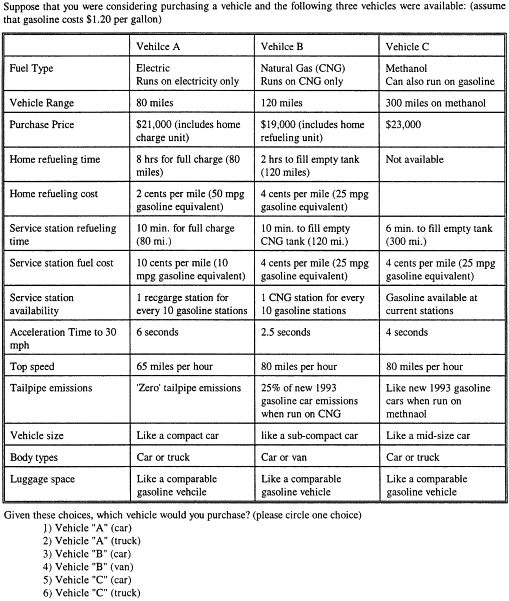

In [137]:
display.Image('brownstone_train_fig_1.gif')

Figure 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

# The IPDL model - Nesting structure

The IPDL model is a generalization of the nested logit model where each alternative may belong to more than one nest. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. For each group of nests $g=1,\ldots, G$, nest membership is denoted by the matrix $\Psi^g\in \mathbb R^{C_g\times J}$: $\Psi^g_{cj}=1$ if product $j$ belongs to nest $c$ and zero otherwise, and each product can only belong to one nest within each group, meaning that $\sum_{c=1}^{C_g}\Psi^g_{cj}=1$ for all $j$ and all $g$. The matrix-vector product $\Psi^gq$ is then
$$
\Psi^g q=\sum_j \Psi^{g}_{cj}q_j=\left(\begin{array}{c}
\sum_{j:\Psi^g_{1j}=1} q_j \\
\vdots \\
\sum_{j: \Psi^g_{C_gj}=1}q_j
\end{array}\right),
$$
and the vector $\Psi^gq$ is a vector of nest-specific choice probabilities, i.e. the sum of the probabilities within each nest.

## The perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the IPDL perturbation function which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\lambda)= (1-\sum_{g=1}^G \lambda_g) q'\ln q +\sum_{g=1}^{G} \lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right).
$$
Note that since $\Psi^g q$ denotes a probability distribution over the nests, the term $(\Psi^gq)'\ln (\Psi^gq)$ is the (negative) entropy of the probability distribution $\Psi^g q$. Note also that as each nest has at least one member, and $q$ is strictly positive, $\Psi^gq$ is also strictly positive. When the parameters $\lambda_g$ satisfy $\lambda_g>0$ and
$$
\sum_g \lambda_g<1,
$$
the function $\Omega(\cdot|\lambda)$ is a strictly convex function of $q$, and the utility maximization problem has a unique interior (meaning strictly positive choice probabilities) solution. When there is only one group of nests, $G=1$, then $\Omega$ induces the nested logit choice probabilities (note though that the nested logit model is often parameterized in terms of the nesting parameter $\mu=1-\lambda$ instead!). 

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}q'u-\Omega(q|\lambda).
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\lambda')'$, the individual choice probabilities is a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}q'\mathbf{X}_i \beta-(1-\sum_{g=1}^G\lambda_g)q'\ln q-\sum_{g=1}^G\lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right)
$$

In [138]:
def Create_incidence_matrix(allocation, x):

    '''
    This function creates the incidence matrices \Psi^g that partition products into nest groupings and nests.
    
    Args.
        allocation: a list of lists with tuples of products j zipped according to their nests in each nest grouping
        x: a matrix of covariates
    
    Output
        psi: a dictionary of the matrices \psi^g as columns
        nests: a numpy array of the amount nests in each nest grouping, i.e. the C_g's
    '''
    
    import numpy as np

    N,J,K = x.shape
    num_groups = len(allocation)

    psi = {}
    nests = np.empty((num_groups))

    for g in np.arange(num_groups):
        nests[g] = len(allocation[g])   # Creates a vector of the numbers C^g
        mat = np.zeros((int(nests[g]), J))

        for k in range(int(nests[g])):
            mat[k, (allocation[g])[k]] = 1  # Assigns a 1 if product j is in the k'th nest in nest grouping g and zero else
        
        psi[g] = mat

    return psi, nests


In the following, we specify some nests for the IPDL model framework. However, these aren't congruent with Figure 1 as our dataset exhibits variation of product characteristics across individuals. This means that the nesting structure should actually vary across individuals. The nests we have chosen are mostly consistent however.

In [139]:
allocation = [[(0,1), (2,3), (4,5)], [(0, 1, 2), (3, 4, 5)]] # We specify a list of lists containing the different nests as zipped tuples of products j. 

# get nest distribution of products
psi_dict, nests = Create_incidence_matrix(allocation, x)
G = len(allocation) # The number of nest groupings G

We have thereby obtained the incidence matrices $\Psi^1$ and $\Psi^2$ for the Fuel Type and Body Type nest groupings, respectively. For illustration, the incidence matrix $\Psi^1$ for the Fuel Type grouping contains the $C_1=3$ nests 'ev', 'cng', and 'methanol' which partition the $J=6$ cars $\{0,1, \ldots , 5\}$ into the given nests. 
Therefore $\Psi^1$ is of dimensions $3 \times 6$ and is given by:

In [140]:
pd.DataFrame(psi_dict[0])

0    1    2    3    4    5
0  1.0  1.0  0.0  0.0  0.0  0.0
1  0.0  0.0  1.0  1.0  0.0  0.0
2  0.0  0.0  0.0  0.0  1.0  1.0

# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.

In [141]:
def CreateGamma(x, Psi, Lambda):
    '''
    This function creates the Gamma matrix. 
    
    Args.
        x: a numpy matrix (N,J,K) of covariates
        Psi: a dictionary of the matrices \psi^g as columns as outputted by 'Create_incidence_matrix'
        Lambda: a numpy array (G,) of grouping parameters \lambda_g
    
    Output
        Gamma: a numpy matrix (J + sum(C_g),J) of nesting parameters times nesting distributions
    '''
    assert x.ndim == 3
    assert Lambda.ndim == 1

    N, J, K = x.shape

    Gamma_dict = {}
    for g in np.arange(len(Psi.keys())+1):
        if g == 0:
            Gamma_dict[g] =  [*((1 - np.sum(Lambda))*np.identity(J))]   # The first J rows are assigned to be diagonal matrix with 1 - sum(\lambda_g) along the diagonal
        else:
            Gamma_dict[g] = [*(Lambda[g-1]*Psi[g-1])] # The next sum(C_g) rows are assigned to be the stacked block matrices \lambda_g*\Psi^g

    Gamma = Gamma_dict[0] # We create the Gamma matrix. This command assigns Gamma to initially be the abovementioned diagonal matrix.
    
    if len(Gamma_dict.keys()) > 1:
        for g in np.arange(1,len(Gamma_dict.keys())):
            Gamma = np.concatenate((Gamma, Gamma_dict[g]), axis=0) # Stacks each of the columns of the dictionary 'Gamma_dict' i.e. the \lambda_g*\Psi^g on top of each other.

    return Gamma

We now create the $\Gamma$ matrix from our nest structure, and set the initial grouping parameters such that $\hat \lambda^0 = \left(\frac{1}{10},\frac{1}{10}\right)'$. Note that $\hat \lambda^0 > 0$ and $\sum_g \hat \lambda_g^0 = \frac{1}{5} < 1$ such that $\Omega(\cdot | \hat \lambda^0)$ is strictly convex.

In [142]:
lambda_0 = 0.1*np.ones((G,)) # set the initial lambda parameters to be one tenth for each nest grouping.
gamma = CreateGamma(x, psi_dict, lambda_0)
pd.DataFrame(gamma)

0    1    2    3    4    5
0   0.8  0.0  0.0  0.0  0.0  0.0
1   0.0  0.8  0.0  0.0  0.0  0.0
2   0.0  0.0  0.8  0.0  0.0  0.0
3   0.0  0.0  0.0  0.8  0.0  0.0
4   0.0  0.0  0.0  0.0  0.8  0.0
5   0.0  0.0  0.0  0.0  0.0  0.8
6   0.1  0.1  0.0  0.0  0.0  0.0
7   0.0  0.0  0.1  0.1  0.0  0.0
8   0.0  0.0  0.0  0.0  0.1  0.1
9   0.1  0.1  0.1  0.0  0.0  0.0
10  0.0  0.0  0.0  0.1  0.1  0.1

We remark that $\Gamma$ is of dimensions $11 \times 6$ since $J + C_1 + C_2 = 6 + 3 + 2 =11$ in the above example. 

## Model solution

While it is possible to solve for the choice probabilities explicitly by maximizing utility, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Suppose we are evaluating the likelihood at some guess of the parameters $\theta=(\beta',\lambda')$. Let $u_i=\mathbf{X}_i\beta$, and let $q_i^0$ denote some initial vector of choice probabilities e.g. $q^0_i=\frac{e^{u_i}}{\sum_{j'=1}^Je^{u_{ij'}}}$, we update the choice probabilities according to the formula
$$
v_i^{k} =u_i+\ln q_i^{k-1}-\Gamma'\ln (\Gamma q_i^{k-1})\\
q_i^{k} = \frac{e^{v_i^{k}}}{\sum_{j=1}^J e^{v_{ij}^{k}}},
$$
they show that $\lim_{k\rightarrow \infty}q_i^k=p(\mathbf{X}_i,\theta)$ for any starting value $q^0_i$ in the interior of $\Delta$. For numerical stability, it can be a good idea to also do max-rescaling of $v^k_i$ at every iteration.

Let $p$ denote the solution to the utility maximization problem. Formally, the Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p||q^{k+1})\leq (\sum_g \lambda_g)D_{KL}(p||q^k),
$$
Noting that $(1-\sum_g \lambda_g)\in [0,1)$ by assumption.

In our example, we set $q_i^0$ equal to the standard logit choice probabilities that we found earlier, and if $\hat \beta^{logit}$ denotes our earlier logit estimates, we set our initial guess of parameters such that $\hat \theta^0 = ({\hat \beta^{logit}}', {\lambda^{0}}')'$.

In [143]:
def IPDL_ccp(Beta, x, Gamma, tol = 1.0e-15, maximum_iterations = 1000, MAXRESCALE:bool = True):
    ''' 
    This function finds approximations to the true conditional choice probabilities.

    Args.
        Beta: a numpy array (K,) of parameters
        x: a numpy matrix (N,J,K) of covariates
        Gamma: a numpy matrix (J + sum(C_g),J) of nesting parameters times nesting distributions as outputted by 'CreateGamma'
        tol: tolerated approximation error
        maximum_iterations: a no. of maximum iterations which if reached will stop the algorithm
        MAXRESCALE: whether or not to max rescale the choice probabilities during iteration

    Output
        q_1: a numpy matrix (N,J) of approximative IPDL choice probabilities
    '''

    u = util(Beta, x)   # Find deterministic utility
    q_0 = logit_ccp(Beta, x)    # Find logit choice probabilities
    q = q_0
    
    eps = 1.0e-15

    assert u.ndim == 2
    assert q.ndim == 2
    assert Gamma.ndim == 2

    for k in np.arange(maximum_iterations):

        # Calculate gamma*log(gamma*q^(k-1))
        gamma_q = np.einsum('cj,nj->cn', Gamma, q) # First we calculate Gamma*q^(k-1)
        log_gamma_q = np.log(gamma_q + eps) # Then we calculate log(Gamma*q^(k-1) + eps) where we add eps to bound the input to np.log away from 0 or below.
        gamma_log_prod = np.einsum('cj,cn->nj', Gamma, log_gamma_q) # Finally we multiply Gamma and log(Gamma*q^(k-1)) 

        # Calculate indirect utilities
        v = u + np.log(q + eps) - gamma_log_prod

        if MAXRESCALE:
            v -= v.max(axis=1, keepdims=True) # Max rescaling to imporve numerical stability

        # Calculate iterated ccps
        denom = np.exp(v).sum(axis=1, keepdims = True) # (N,1)
        q_1 = np.exp(v) / denom

        # Check convergence in an appropriate distance function
        dist = np.max(np.sum((q_1-q)**2/q_0 , axis=1)) # Uses logit weights. This avoids precision issues when q1~q~0.

        if dist<tol:
            num_iter=k
            break
        if k==maximum_iterations:
            num_iter=maximum_iterations
        # Iteration step
        q = q_1
    
    return q_1,num_iter

### Find some IPDL choice probabilities $\hat q_i^{IDPL}$ for individuals $i=0,1, \ldots, 4653$ and guess parameters $\hat \theta^0 = ({\hat \beta^{logit}}', {\lambda^{0}}')'$.


In [144]:
p,num_iter= IPDL_ccp(logit_beta, x, gamma) # note that our initial guess parameters \lambda^0 enter in the Gamma matrix only
print(f"Number of iterations performed:  {num_iter}")

pd.DataFrame(p)

Number of iterations performed:  10


0         1         2         3         4         5
0     0.120609  0.327414  0.210956  0.103217  0.134994  0.102810
1     0.242507  0.089332  0.303758  0.054051  0.242359  0.067993
2     0.205620  0.057686  0.245616  0.090881  0.343226  0.056972
3     0.138231  0.038780  0.177109  0.060520  0.502029  0.083331
4     0.085097  0.023874  0.176239  0.057877  0.563397  0.093517
...        ...       ...       ...       ...       ...       ...
4649  0.170227  0.047757  0.214351  0.076317  0.421400  0.069948
4650  0.226047  0.063417  0.338955  0.133336  0.204330  0.033916
4651  0.114661  0.150554  0.039621  0.021147  0.147666  0.526352
4652  0.043763  0.155994  0.272676  0.353127  0.109596  0.064844
4653  0.093772  0.034543  0.231468  0.035751  0.472038  0.132429

[4654 rows x 6 columns]

## Maximum likelihood estimation of IPDL with numerical gradients

The log-likelihood contribution is
$$
\ell_i(\theta)=y_i'\ln p(\mathbf{X}_i,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_i$ and $\theta$ - calculates $u_i=\mathbf{X}_i\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_i,\theta)$, and we can then evaluate $\ell_i(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

In [145]:
def IPDL_loglikelihood(Theta, y, x, Psi):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a numpy array (N,) of observed choices,
        x: a numpy matrix (N,J,K) of covariates,
        Psi: a dictionary of the matrices \psi^g as columns as outputted by 'Create_incidence_matrix'

    Output
        ll: a numpy array (N,) of IPDL loglikelihood contributions
    '''

    N,J,K = x.shape
    G = len(Psi.keys())

    gamma = CreateGamma(x, Psi, Theta[K:]) # The last G parameters of theta are the nesting parameters \lambda_g
    ccp_hat = IPDL_ccp(Theta[:K], x, gamma)[0] # The first K parameters of theta are those of \beta

    ll = np.log(ccp_hat[np.arange(N), y]) # For each individual find (the log of) the choice probability of the chosen alternative

    return ll

In [146]:
def q_IPDL(Theta, y, x, Psi):
    '''q_IPDL: Criterion function, passed to estimate_IPDL().
    '''
    return -IPDL_loglikelihood(Theta, y, x, Psi)

In [147]:
def estimate_IPDL(q, Theta0, y, x, Psi, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args:
    q: a function to minimize,
    Theta0 : (K+G,) array of initial guess parameters,
    y: array of observed response variables (N,),
    x: array of observed explanatory variables (N,J,K),
    Psi: dictionary of nesting distributions outputted by 'Create_incidence_matrix',
    options: dictionary with options for the optimizer (e.g. disp=True,
        which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(q(Theta, y, x, Psi))

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, **kwargs)

    # collect output in a dict 
    res = {
        'theta': result.x,
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

Estimating the IPDL model using maximum likelihood with initial guess of parameters $\hat \theta^0 = ({\hat \beta^{logit}}', {\lambda^{0}}')'$ then yields...

In [148]:
logit_theta = np.array([*logit_beta, *lambda_0])

# Estimate the IPDL model
res_IPDL = estimate_IPDL(q_IPDL, logit_theta, y, x, psi_dict)

Optimization terminated successfully.
         Current function value: 1.575854
         Iterations: 84
         Function evaluations: 2064
         Gradient evaluations: 86


In [149]:
IPDL_theta = res_IPDL['theta']
pd.DataFrame(IPDL_theta.reshape(1,len(IPDL_theta)))

0         1         2        3         4         5         6   \
0 -0.110085  0.232632 -0.457753  0.18933 -0.278105  0.631604  0.078315   

         7        8         9   ...        13        14        15      16  \
0  0.304099 -0.49083  0.258482  ... -0.235755 -0.153668 -0.213903  0.1262   

         17        18        19        20        21        22  
0  0.256145  0.129071  0.158435  0.116742  0.452528  0.351416  

[1 rows x 23 columns]

Next, we use the Maximum Likelihood estimates to find the implied choice probabilities of our IPDL model

In [150]:
gamma_hat = CreateGamma(x, psi_dict, IPDL_theta[K:K+G])
ccp_hat_IPDL = IPDL_ccp(IPDL_theta[0:K], x, gamma_hat)[0]
pd.DataFrame(ccp_hat_IPDL)

0         1         2         3         4         5
0     0.093428  0.204586  0.245409  0.155348  0.181692  0.119536
1     0.191896  0.087633  0.273682  0.084924  0.278262  0.083602
2     0.199207  0.059851  0.226299  0.093041  0.347979  0.073623
3     0.152024  0.045675  0.200163  0.043492  0.461091  0.097555
4     0.097747  0.029368  0.227782  0.035640  0.503034  0.106429
...        ...       ...       ...       ...       ...       ...
4649  0.166694  0.050082  0.229465  0.071166  0.398319  0.084274
4650  0.198616  0.059673  0.279873  0.168121  0.242425  0.051291
4651  0.128157  0.194795  0.079501  0.027567  0.131684  0.438297
4652  0.035110  0.116861  0.298629  0.318160  0.135688  0.095552
4653  0.098393  0.044933  0.258415  0.026779  0.439449  0.132030

[4654 rows x 6 columns]

## Demand derivatives and price Elasticity

While the demand derivatives in the IPDL model are not quite as simple as in the logit model, they are still easy to compute. 
Let $q=P(u|\lambda)$, then
$$
\nabla_u P(u|\lambda)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse. The derivatives with respect to any $x_{ij\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\lambda)=\mathrm{diag}(P(u|\lambda))^{-1}\nabla_u P(u|\lambda).
$$

In [151]:
def compute_pertubation_hessian(q, x, Lambda, Psi):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a (N,J) numpy array of choice probabilities
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Hess: a (N,J,J) numpy array of second partial derivatives of the pertubation function \Omega
    '''

    Gamma = CreateGamma(x, Psi, Lambda)

    assert q.ndim == 2
    assert Lambda.ndim == 1

    N,J,K = x.shape
    C = Gamma.shape[0]

    gamma_q = np.einsum('cj,nj->nc', Gamma, q)
    diag_gamma_q_inv = np.einsum('nc,ci->nci', 1./gamma_q, np.eye(C))
    Hess = np.einsum('cj,nci,ck->njk', Gamma, diag_gamma_q_inv, Gamma)

    return Hess

In [152]:
def ccp_gradient(q, x, Lambda, Psi):
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Grad: a (N,J,K) numpy array of partial derivatives of the choice proabilities wrt. characteristics
    '''

    assert q.ndim == 2

    N,J,K = x.shape

    inv_omega_hess = la.inv(compute_pertubation_hessian(q, x, Lambda, Psi)) # (N,J,J) # For each i, computes the inverse of the J*J Hessian
    qqT = np.einsum('nj,ni->nji', q, q) # (N,J,J)
    Grad = inv_omega_hess - qqT

    return Grad

In [153]:
def IPDL_elasticity(q, x, Theta, Psi, char_number):
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Epsilon: a (N,J,K) numpy array of partial derivatives of the choice proabilities wrt. characteristics
    '''

    assert q.ndim == 2

    N,J,K = x.shape
    
    ccp_grad = ccp_gradient(q, x, Theta[K:], Psi)
    diag_q_inv = np.einsum('nj,ji->nji', 1./q, np.eye(J))
    Epsilon = np.einsum('nji,nil->njl', diag_q_inv, ccp_grad)*Theta[char_number]

    return Epsilon

Using the these functions and our earlier estimates and choice probabilities we can find the implied choice probability elasticities with respect to price-to-log-income. For individual $i=0$ we find:

In [154]:
epsilon_IPDL = IPDL_elasticity(ccp_hat_IPDL, x, IPDL_theta, psi_dict, 0)
pd.DataFrame(epsilon_IPDL[0,:,:])

0         1         2         3         4         5
0 -0.419250  0.311493  0.069418  0.000916  0.022572  0.014851
1  0.142249 -0.250007  0.069418  0.000916  0.022572  0.014851
2  0.026428  0.057871 -0.197768  0.102904  0.006373  0.004193
3  0.000551  0.001207  0.162562 -0.274186  0.066269  0.043598
4  0.011607  0.025417  0.008608  0.056660 -0.284519  0.182227
5  0.011607  0.025417  0.008608  0.056660  0.276981 -0.379273

Again we find for individual $i=0$ that all the diangonal entries are negative, whence all products $j$ are normal. Furthermore, note that the general IIA property no longer holds. Instead, products $j_1,j_2$ which are of the same 'type' (i.e. for all nest groupings $g=1,2$ products $j_1$ and $j_2$ belong to the same nest), have the same cross-elasticities with respect to any product $\ell \neq j_1, j_2$. For example, products $j_1=0$ and $j_2=1$ are both in the 'EV'- and 'Car'- nests, such that they of the same type, and we see that for $\ell = 2$ the price-to-log-income elasticities are equal: $\mathcal{E}_{02} = 0.069 = \mathcal{E}_{12}$.

### Visualization of elasticities

First we plot the elasticities of the Logit model in a matrix of histograms. The red dotted line indicates the elasticity $\mathcal{E}^* = 0$.

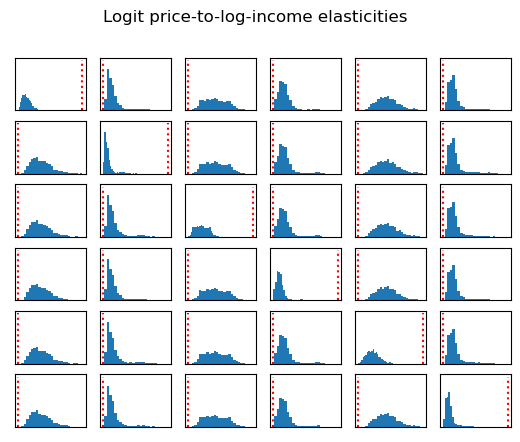

In [155]:
own_elasticities_logit = {j : (epsilon_logit.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income elasticities')

plt.show()

Similarly we plot histograms of the elasticities for the IDPL model.

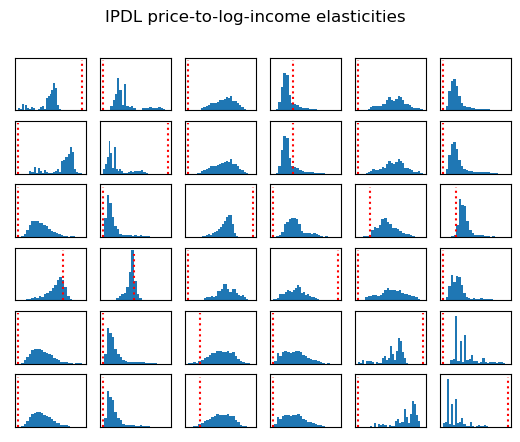

In [156]:
own_elasticities_IPDL = {j : (epsilon_IPDL.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_IPDL[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('IPDL price-to-log-income elasticities')
plt.show()

## Fosgerau, Kristensen \& Nielsen estimation algorithm

#### Initial Estimator

The FKN estimator is initialized by a set of initial choice probabilities $\hat q_i$ for each individual. The initial FKN estimator minimizes the residuals
$$
\hat \varepsilon_i(\theta)=\mathrm{diag}(\hat q_i)\left( u(x_i,\beta)-\nabla_q \Omega(\hat q_i|\lambda)\right)-y_i+\hat q_i
$$
using the weighted least squares estimator
$$
\hat \theta^0 = \arg \min \frac{1}{n}\sum_i \hat \varepsilon_i(\theta)'\hat W_i\hat \varepsilon_i(\theta),
$$
where $\hat W_i=\mathrm{diag}(\hat q_i)^{-1}-\iota \iota'$. When $u$ and $\nabla_q \Omega$ are linear in the parameters, this may be written as
$$
\hat \varepsilon_i(\theta)=\hat G_i\theta-\hat r_i,
$$
where
$$
    \hat G_i=\mathrm{diag}(\hat q_i)\left[X_i,\hat{Z}_i \right],\quad \hat Z_{ijg}=\ln \hat q_{ij} -\left[(\Psi^g)'\ln \Psi^g\hat q_i\right]_j, \quad \hat r_i =\mathrm{diag}(\hat q_i)\ln \hat q_i-y_i+\hat q_i
$$
In that case, we obtain the closed-form solution
$$
\hat \theta^0 = \left( \frac{1}{n}\sum_i \hat G_i'\hat W_i\hat G_i\right)^{-1}\left( \frac{1}{n}\sum_i \hat G_i'\hat W_i \hat r_i\right),
$$

We now construct the necessary functions.

In [159]:
def LogL(theta):
    ''' 
    Just useful to have.
    '''
    return np.mean(IPDL_loglikelihood(theta, y, x, psi_dict))

In [160]:
def WeightedLeastSquares(G,W,r):
    N=G.shape[0]
    
    GWG=np.einsum('nja,njk,nkb->ab',G,W,G,optimize=True)/N
    GWr=np.einsum('nja,njk,nk->a',G,W,r,optimize=True)/N
    
    theta_hat=la.solve(GWG,GWr)
    cov_hat=la.inv(GWG)/N
    se_hat=np.sqrt(np.diag(cov_hat))
    
    return theta_hat,se_hat
    

In [162]:
def Z_array(psi,q):
    
    N,J=q.shape
    G=len(psi)
    Z=np.empty((N,J,G))
    log_q=np.log(q)
    
    for g in range(G):
        Psi=psi[g]
        Psiq=np.einsum('cj,nj->nc', Psi,q)
        # Psi[None,:,:]@q ?
        
        log_Psiq=np.log(Psiq)
        Psi_log_Psiq=np.einsum('cj,nc->nj', Psi,log_Psiq)
        # Psi.T[None,:,:]@ log_Psiq ?
                
        Z[:,:,g]=log_q-Psi_log_Psiq
        
    return Z

In [163]:
def FKN_Initial(y,x,psi,q,alpha=1):
    
    '''
    Returns the initial FKN estimator. alpha is a regularization parameter. As alpha->, goes towards logit_theta
    '''
    Z=Z_array(psi,q)
    XZ=np.concatenate( (x,Z) ,axis=2) 
    
    G=q[:,:,None]*XZ # equal to
    W=1./q[:,:,None]*np.eye(q.shape[1])[None,:,:]-1
    
    # returns W[i,:,:]= diag(1/q)-\iota \iota.

    #W=np.einsum('ij,jl->ijl',1./q,np.eye(q.shape[1]))-1 
    
    r=q*np.log(q)- alpha*(y-q)
    
    theta_hat,se_hat=WeightedLeastSquares(G,W,r)
    
    return theta_hat,se_hat

In [ ]:
theta_FKN,se_FKN=FKN_Initial(y_onehot,x,psi_dict,logit_q,alpha=-0.9)

In [ ]:
theta_FKN

In [ ]:
IPDL_theta

Unfortunately, here we see that we do not obtain a particularly good fit (In fact, we get negative lambda parameters). We therefore need some regularization or a better starting estimator.

Instead, what we can do is construct the iterated estimator, starting from the initial guess logit_theta.

## Iterated FKN estimator

Starting from an earlier estimator $\hat \theta^{k-1}$, the iterated version of the FKN estimator first computes the choice probabilities and Hessian at $\hat \theta^{k-1}$,
$$
\hat q^k_i=p(\mathbf X_i,\hat \theta^{k-1})\\
\hat D^k_i=\nabla^2_{qq}\Omega(\hat q_i^k|\hat \lambda^{k-1})
$$
and then constructs the residual
$$
\hat \varepsilon^k_i(\theta)=\hat D^k_i\left( u(x_i,\beta)-\nabla_q \Omega(\hat q_i^k|\lambda)\right) -y_i+\hat q_i^k,
$$
which we can once again write as
$$
\hat \varepsilon^k_i(\theta)= \hat G_i^k \theta-\hat r^k_i,
$$
where now
$$
\hat G^k_i=\hat D_i^k\left[X_i,\hat{Z}^k_i \right],\quad \hat Z_{ijg}^k=\ln \hat q^k_{ij} -\left[(\Psi^g)'\ln \Psi^g\hat q_i^k\right]_j, \quad \hat r_i^k =\mathrm{diag}(\hat q_i^k)\ln \hat q_i^k-y_i+\hat q_i^k
$$

and uses the weighted least squares estimator,
$$
\hat \theta^k = \arg \min_{\theta}\hat \varepsilon^k_i(\theta)'\hat W_i^k \hat \varepsilon^k_i(\theta).
$$
We can once again solve for this as
$$
\hat \theta^k =\left( \frac{1}{n}\sum_i \hat (G^k_i)'\hat W_i^k \hat G^k_i)\right)^{-1}\left( \frac{1}{n}\sum_i (\hat G_i^k)'\hat W_i^k \hat r_i^k\right)
$$
Now we introduce this procedure and iterate on it starting from our initial guess $\hat \theta^0=(\hat \beta_{logit}',(\hat \lambda^0)')'$.


In [164]:
def FKN_Iterated(y,x,psi,theta):
    
    Gamma=CreateGamma(x,psi,theta[K:])
    q=IPDL_ccp(theta[:K],x,Gamma)[0]
    
    Gamma_q=np.einsum('cj,ij->ic',Gamma,q)
    # Gamma[None,:,:]@q
    
    D_inv=np.einsum('cj,ic,ck->ijk',Gamma,1./Gamma_q,Gamma)
    D=np.linalg.inv(D_inv)
    
    Z=Construct_Z(psi,q)
    
    XZ   =  np.concatenate( (x,Z) ,axis=2) 
    
    # np.permute(D, (0,2,1))@ XZ ?
    
    G=  np.einsum('njk,nkl->njl',D,XZ)
    W=1./q[:,:,None]*np.eye(q.shape[1])[None,:,:]-1
    Dlog_q= np.einsum('ijk,ik->ij',D,np.log(q) )
    
    r=Dlog_q-q+y
    
    theta_hat,se_hat=WLS(G,W,r)
    
    return theta_hat,se_hat

In [ ]:
FKN_iters=10
theta_old=logit_theta
THETA=np.empty( (K+G,FKN_iters ))
SE=np.empty( (K+G,FKN_iters ))
LOGL=np.empty(FKN_iters)
for k in range(FKN_iters):
    
    THETA[:,k],SE[:,k]=FKN_Iterated(y_onehot,x,psi_dict,theta_old)
    theta_old=THETA[:,k]
    LOGL[k]=LogL(theta_old)

In [ ]:
LOGL

In [ ]:
THETA[0,:]